In [1]:
# importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

## **1. Data Loading and Inspection**

In [4]:
# load data
df = pd.read_csv('diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
# basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50000 non-null  float64
 1   cut      50000 non-null  object 
 2   color    50000 non-null  object 
 3   clarity  50000 non-null  object 
 4   depth    50000 non-null  float64
 5   table    50000 non-null  float64
 6   price    50000 non-null  int64  
 7   x        50000 non-null  float64
 8   y        50000 non-null  float64
 9   z        50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


In [6]:
# summary statistics
df.describe()

,carat,depth,table,price,x,y,z
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.799444,61.753006,57.457830,3944.805440,5.734403,5.737956,3.541056
std,0.475173,1.431088,2.232092,3997.938105,1.123077,1.145579,0.707065
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2410.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5351.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## **2. Data Cleaning**

In this section, we perform standard data cleaning practices to ensure the dataset is in a favourable condition for EDA and model training

### **2.1 Rename Columns**

In [8]:
# rename x, y, and z columns
df.rename(columns={'x': 'length(mm)', 'y': 'width(mm)', 'z':'depth(mm)'}, inplace=True)

df.head()

,carat,cut,color,clarity,depth,table,price,length(mm),width(mm),depth(mm)
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [10]:
# check for NaN types
empty_vals = df.isna().sum()
print(empty_vals)

carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
length(mm)    0
width(mm)     0
depth(mm)     0
dtype: int64


### **2.2 Check and Handle Duplicates**

In [11]:
# check for duplicates 
df.duplicated().sum()

126

In [12]:
# remove duplicates
df_new = df.drop_duplicates()

### **2.3 Check and Handle Outliers**

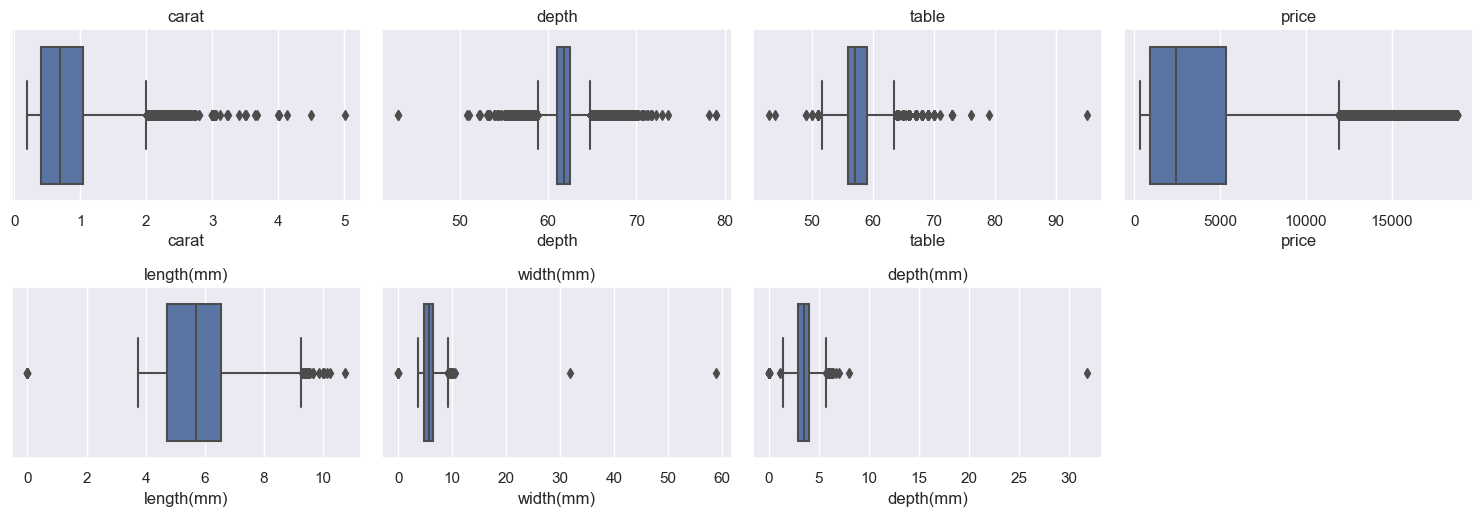

In [14]:
# boxplot of features
# Set the aesthetic style of the plots
sns.set(style="darkgrid")

# Create boxplots for numerical features
numerical_features = df_new.select_dtypes(include=['float', 'int']).columns.tolist()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [16]:
# function to check outliers

def remove_outliers(df):
    outlier_percentages = {}
    
    # Iterate over each numeric column
    for column in df.select_dtypes(include='number'):
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Calculate the percentage of outliers
        outlier_percentage = len(outliers) / len(df) * 100
        outlier_percentages[column] = outlier_percentage
        
        print(f"Column: {column}")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {outlier_percentage:.2f}%")
        
        # Remove outliers if they exceed 20%
        if outlier_percentage > 20:
            df[column] = df.loc[~((df[column] < lower_bound) | (df[column] > upper_bound)), column]
            print("Outliers removed due to exceeding 20% threshold.")
        else:
            print("No outliers removed.")
        
        print()
    
    return df, outlier_percentages

In [17]:
df_cleaned, outlier_percentages = remove_outliers(df_new)

Column: carat
Number of outliers: 1757
Percentage of outliers: 3.52%
No outliers removed.

Column: depth
Number of outliers: 2340
Percentage of outliers: 4.69%
No outliers removed.

Column: table
Number of outliers: 557
Percentage of outliers: 1.12%
No outliers removed.

Column: price
Number of outliers: 3255
Percentage of outliers: 6.53%
No outliers removed.

Column: length(mm)
Number of outliers: 31
Percentage of outliers: 0.06%
No outliers removed.

Column: width(mm)
Number of outliers: 28
Percentage of outliers: 0.06%
No outliers removed.

Column: depth(mm)
Number of outliers: 43
Percentage of outliers: 0.09%
No outliers removed.



In [19]:
df_cleaned.head()

,carat,cut,color,clarity,depth,table,price,length(mm),width(mm),depth(mm)
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## **3. EDA**  

In this section, we perform Exploratory Data Analysis where we look at various characteristics of the dataset such as distributions, correlations, etc.

### **3.1 Distributions**

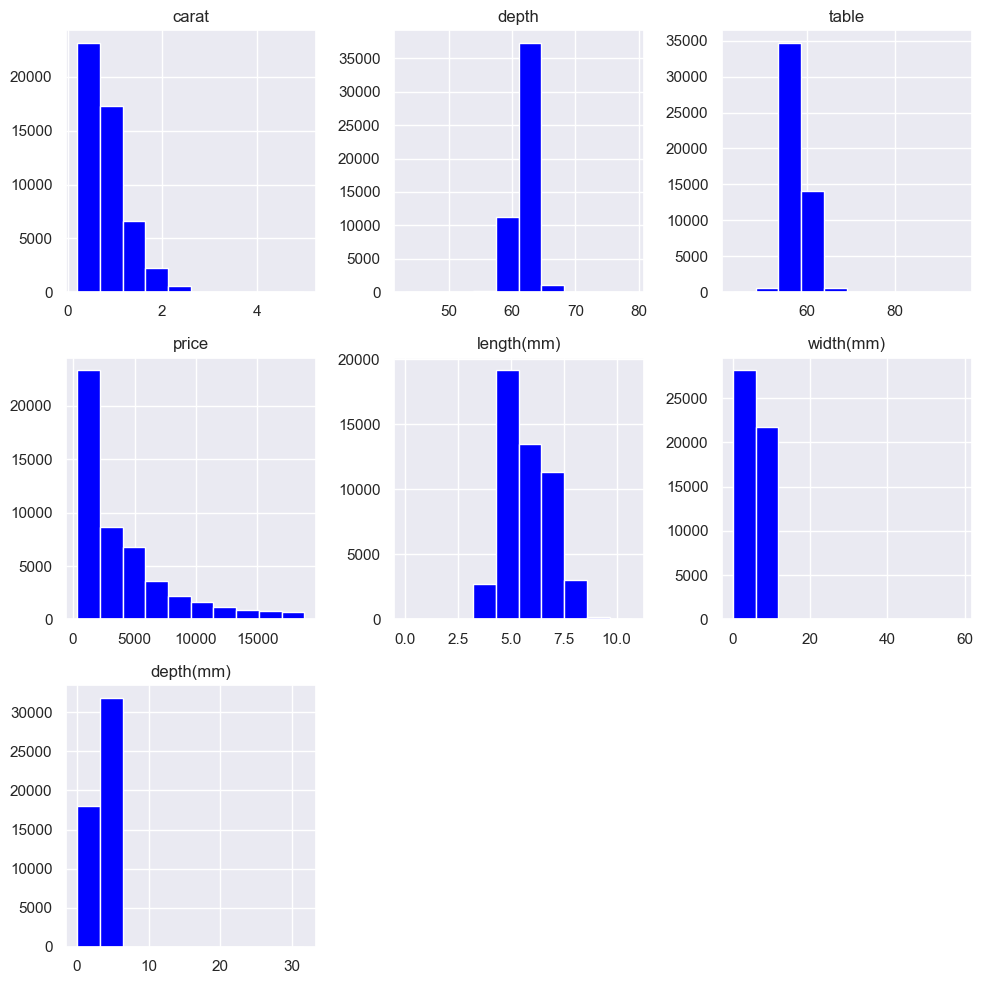

In [24]:
# histogram
df_cleaned.hist(figsize=(10,10), color = 'blue')
plt.tight_layout()
plt.show()